In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Análisis Exploratorio de datos (EDA)

In [2]:
results_df = pd.read_csv('../results/execution_time.csv')
results_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,vendor_id_raw,arch,count,l2_cache_size,l3_cache_size,hz_actual_friendly,hz_advertised_friendly,l2_cache_line_size,l2_cache_associativity,benchmark
0,13.49,99%,1470312,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12,1.5 MiB,12582912,4.0996 GHz,2.9000 GHz,256,6,KNP
1,13.32,99%,1470608,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12,1.5 MiB,12582912,4.0996 GHz,2.9000 GHz,256,6,KNP


In [3]:
results_savio_df = pd.read_csv('../results_savio/execution_time.csv')
results_savio_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,vendor_id_raw,arch,count,l2_cache_size,l3_cache_size,hz_actual_friendly,hz_advertised_friendly,l2_cache_line_size,l2_cache_associativity,benchmark
0,20.81,98%,1466524,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24,6291456,31457280,1.2000 GHz,2.3000 GHz,256,6,KNP
1,21.05,99%,1465000,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24,6291456,31457280,1.2000 GHz,2.3000 GHz,256,6,KNP


In [4]:
def bits_to_MiB(row):
    # verify if has string ' MiB'
    if 'MiB' in str(row):
        row = row.replace(' MiB', '')
        row = float(row)
    else:
        row = float(row) / np.power(2, 20)
    return row


def MHz_to_GHz(row):
    # verify if has string ' GHz'
    if 'GHz' in str(row):
        row = row.replace(' GHz', '')
        # convert to float
        row = float(row)
    else:
        row = row.replace(' MHz', '')
        row = float(row) / 1000
    return row

In [5]:
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / 1024
results_df['l2_cache_size'] = results_df['l2_cache_size'].apply(bits_to_MiB)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].apply(MHz_to_GHz)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly'])

In [6]:
results_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,vendor_id_raw,arch,count,l2_cache_size,l3_cache_size,l2_cache_line_size,l2_cache_associativity,benchmark,ghz_actual_friendly,ghz_advertised_friendly
0,13.49,0.99,1435.851562,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12,1.5,12582912,256,6,KNP,4.0996,2.9
1,13.32,0.99,1436.140625,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12,1.5,12582912,256,6,KNP,4.0996,2.9


## PC's utilizados

In [7]:
# Count = Threads
results_df[['brand_raw','vendor_id_raw','arch','count']].drop_duplicates()

,brand_raw,vendor_id_raw,arch,count
0,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12
20,13th Gen Intel(R) Core(TM) i5-1335U,GenuineIntel,X86_64,12
40,11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz,GenuineIntel,X86_64,8
60,12th Gen Intel(R) Core(TM) i5-12400F,GenuineIntel,X86_64,12
80,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24
100,Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz,GenuineIntel,X86_64,8
120,Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz,GenuineIntel,X86_64,40
140,Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz,GenuineIntel,X86_64,56


## Benchmarks

### General

In [8]:
results_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,160.000000,160.000000,160.000000
mean,19.702875,3.501062,958.941211
std,7.847944,5.299265,997.146127
min,3.580000,0.980000,10.199219
25%,16.180000,0.990000,22.928711
50%,19.680000,0.990000,731.062500
75%,24.367500,1.230000,1659.728516
max,47.940000,24.310000,2452.847656


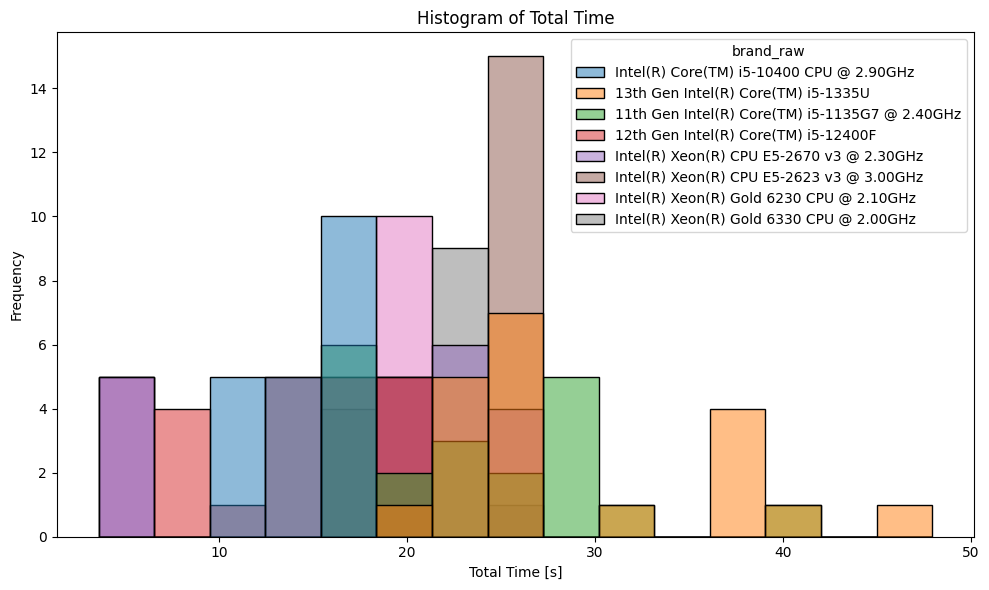

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(results_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time [s]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

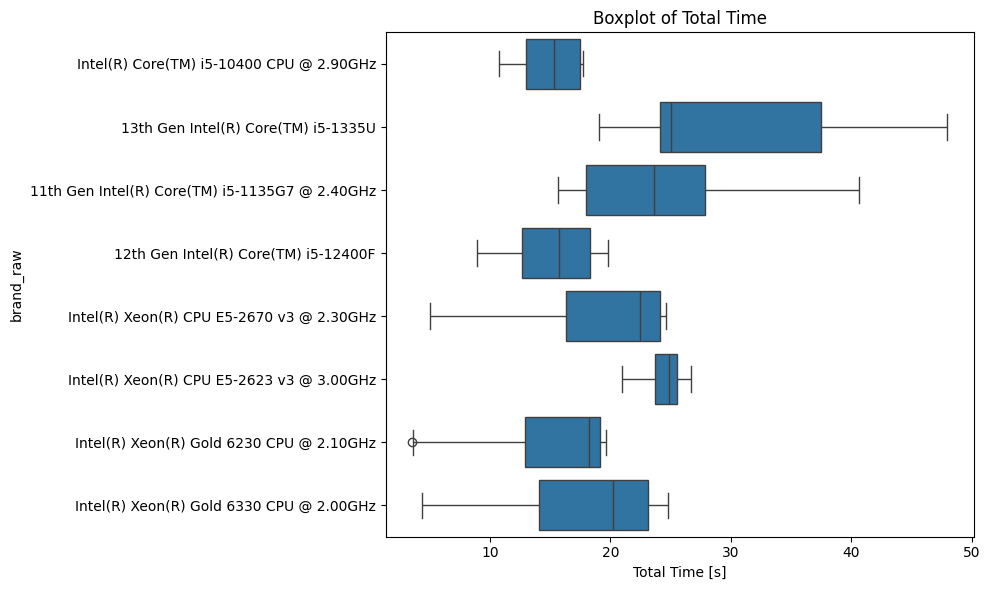

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time [s]')

plt.tight_layout()
plt.show()

Existe una gran variabilidad en los resultados, por que se están midiendo varias pruebas.

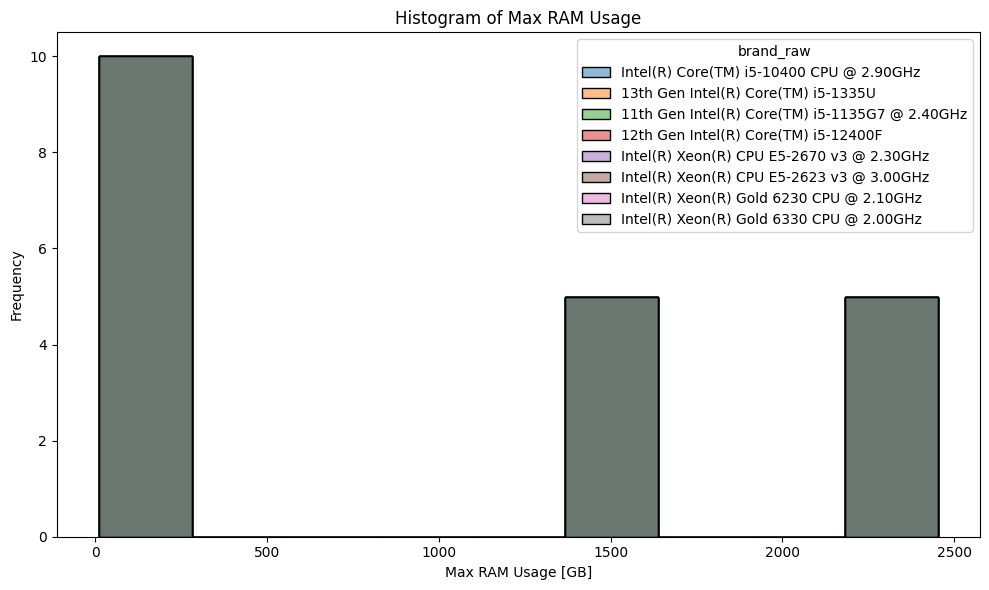

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(results_df, x='max_ram_usage', hue='brand_raw')
plt.title('Histogram of Max RAM Usage')
plt.xlabel('Max RAM Usage [GB]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

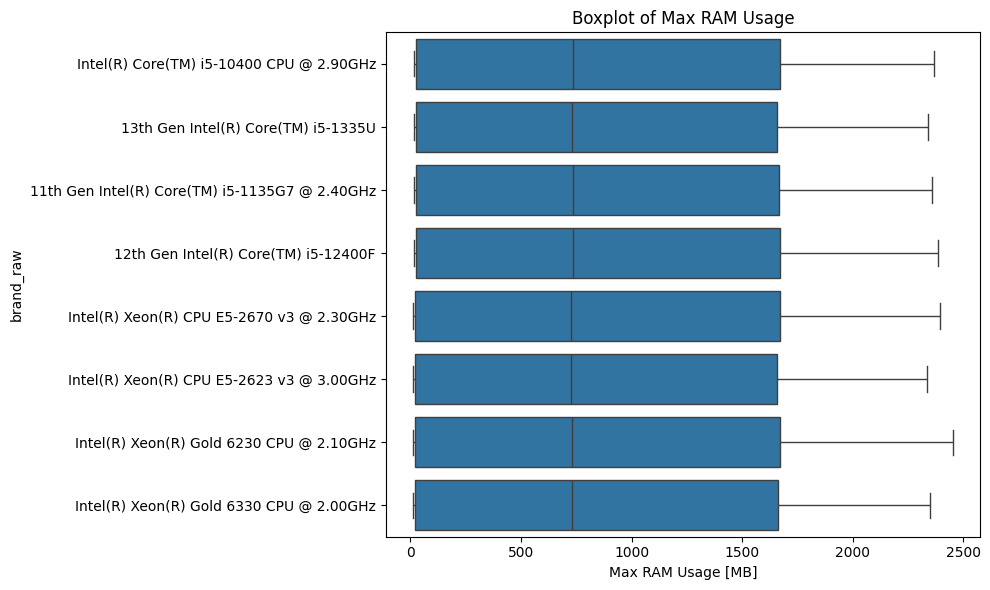

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='max_ram_usage', y='brand_raw')
plt.title('Boxplot of Max RAM Usage')
plt.xlabel('Max RAM Usage [MB]')

plt.tight_layout()
plt.show()

Al abarcar todos los benchmarks se espera que el rendimiento sea similar en todos los casos, al igual que el consumo de RAM (en cada computadora, pero no en cada benchmark).

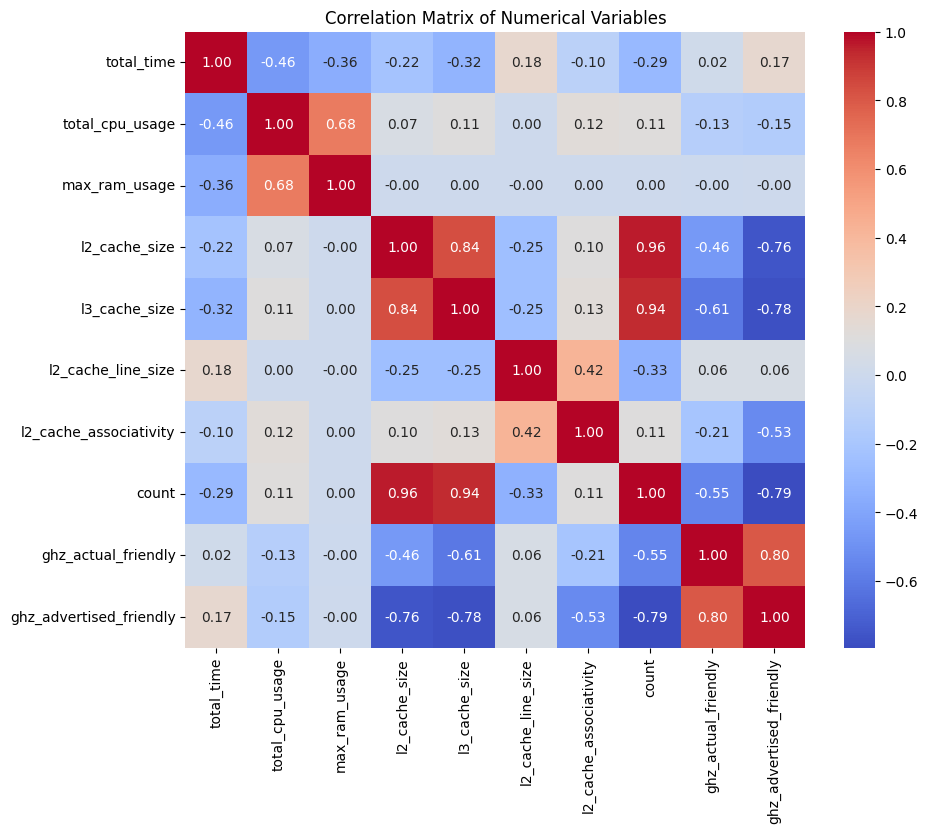

In [23]:
correlation_matrix = results_df[['total_time', 'total_cpu_usage', 'max_ram_usage','l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

Conclusiones:
- Las correlaciones negativas entre `total_time` y `total_cpu_usage` o `max_ram_usage` sugieren que un uso más eficiente de recursos (CPU y RAM) tiende a reducir el tiempo total de ejecución.
- `ghz_actual_friendly` tiene una fuerte correlación negativa con `total_time`, lo que sugiere que mayores frecuencias de procesador están asociadas con menores tiempos de ejecución.

### General menos Matrix multiplication
Se excluye dado que se ocupa multi-nucleo y no se puede comparar con el resto de los benchmarks

In [14]:
general_df = results_df[results_df['benchmark']!='MATRIX_MULT']

In [15]:
general_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,120.000000,120.000000,120.000000
mean,21.002500,0.990083,491.724186
std,4.362386,0.002424,669.199304
min,13.320000,0.980000,10.199219
25%,17.745000,0.990000,15.454102
50%,20.875000,0.990000,28.068359
75%,24.247500,0.990000,1432.627930
max,38.450000,1.000000,1437.281250


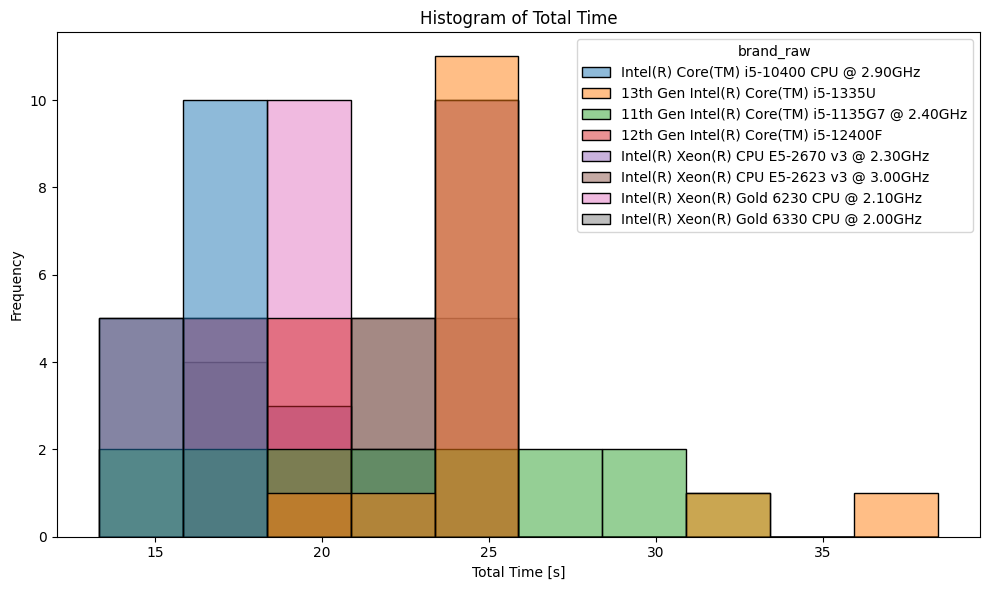

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(general_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time [s]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

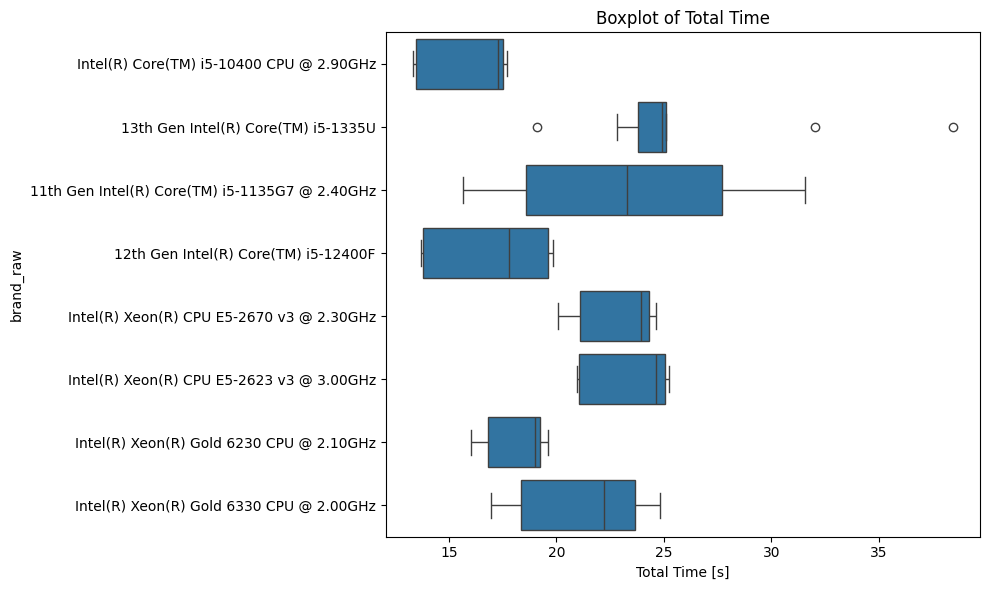

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=general_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time [s]')

plt.tight_layout()
plt.show()

Existe una gran variabilidad en los resultados, por que se están midiendo varias pruebas.

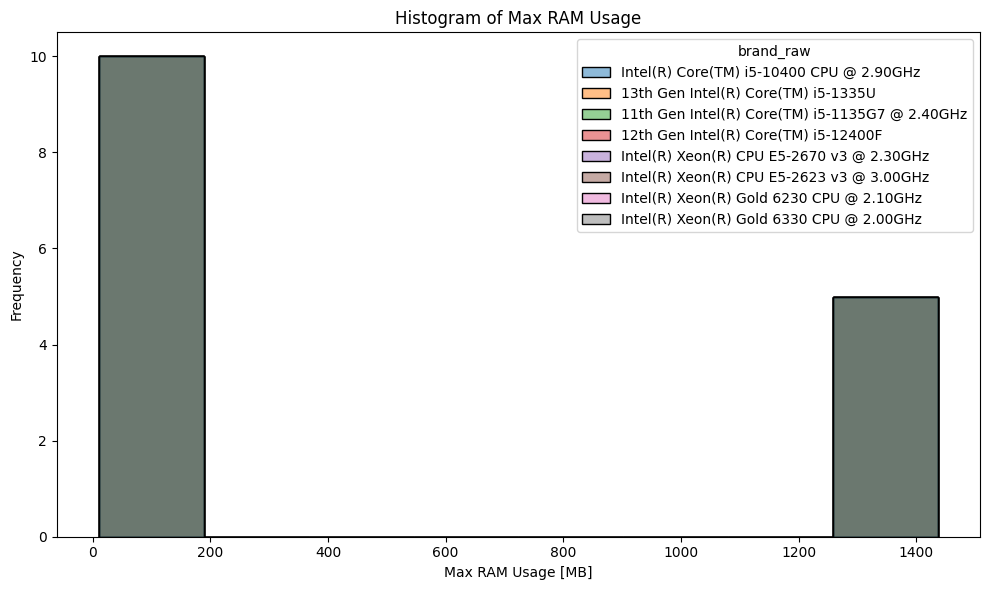

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(general_df, x='max_ram_usage', hue='brand_raw')
plt.title('Histogram of Max RAM Usage')
plt.xlabel('Max RAM Usage [MB]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

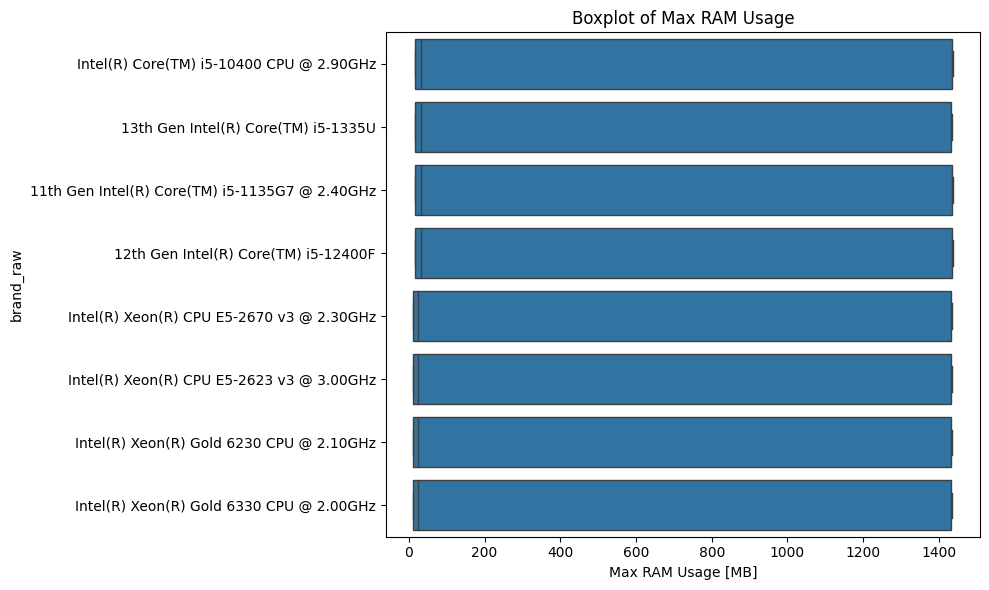

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=general_df, x='max_ram_usage', y='brand_raw')
plt.title('Boxplot of Max RAM Usage')
plt.xlabel('Max RAM Usage [MB]')

plt.tight_layout()
plt.show()

Al abarcar todos los benchmarks se espera que el rendimiento sea similar en todos los casos, al igual que el consumo de RAM (en cada computadora, pero no en cada benchmark).

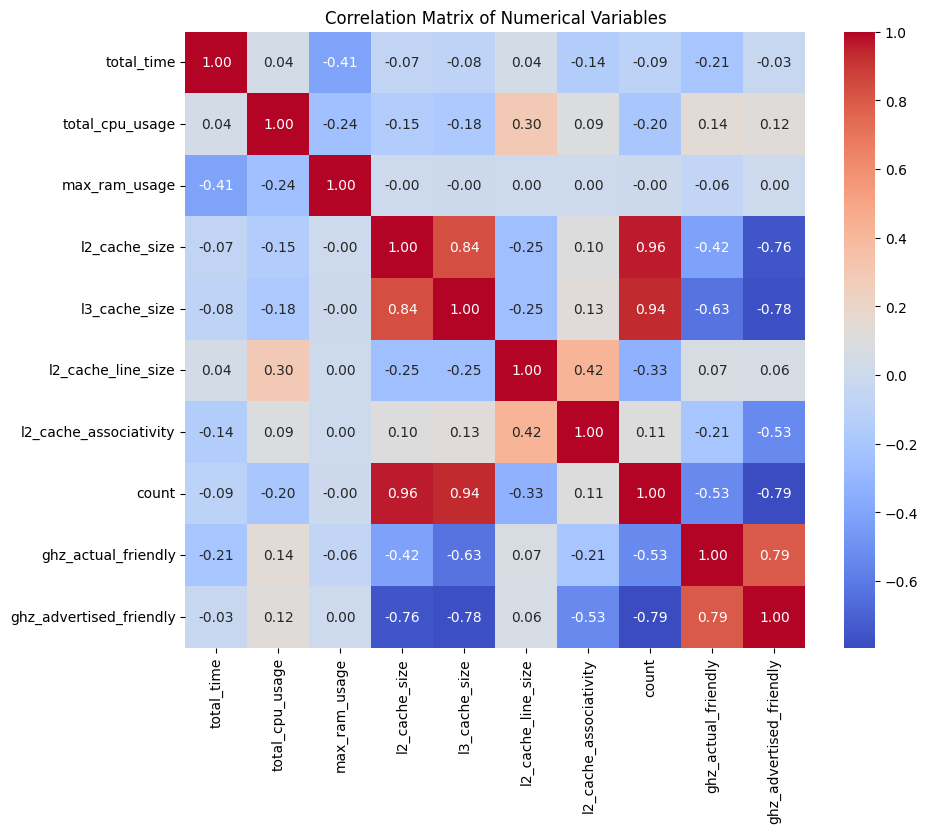

In [20]:
correlation_matrix = general_df[['total_time', 'total_cpu_usage', 'max_ram_usage','l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

Conclusiones:
- Dado que hay una correlación negativa moderada entre el uso máximo de RAM y el tiempo total de ejecución, optimizar el uso de RAM podría ayudar a reducir los tiempos de ejecución.
- Al siempre estar un núcleo al 100% de uso, en este caso la cantidad de núcleos `count` no influye en el tiempo de ejecución, lo que causa que otras variables como `total_cpu_usage` tenga una correlación muy cercana a 0 con el tiempo total de ejecución, lo que podría ser un indicador de que no es una variable relevante para predecir el tiempo total de ejecución en casos con un solo núcleo.

Hay dos puntos a tener en cuenta, con lo mostrado en el mapa de correlaciones:
- **No linealidad**:  Algunas variables pueden tener relaciones no lineales con el tiempo total de ejecución. Por ejemplo, el uso de CPU y el uso de RAM podrían tener interacciones complejas. Donde por ejemplo, la combinación de `l2_cache_size`, `count` y `ghz_actual_friendly` podría tener un efecto no lineal en el tiempo total de ejecución.
- **Multicolinealidad**: Algunas variables pueden estar altamente correlacionadas entre sí. Por ejemplo, `l2_cache_size` y `l3_cache_size` tienen una correlación positiva alta. Esto podría causar problemas en los modelos de regresión, ya que la multicolinealidad puede hacer que los coeficientes de los predictores sean difíciles de interpretar.

### Matrix multiplication (10000x10000)

In [15]:
mm_df = results_df[results_df['benchmark']=='MATRIX_MULT']

In [16]:
# total_memory_usage and swaps are not available for containerized benchmarks
mm_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,40.000000,40.000000,40.000000
mean,15.804000,11.034000,2360.592285
std,13.124155,6.073616,23.873077
min,3.580000,1.920000,2327.070312
25%,5.070000,7.392500,2346.015625
50%,10.195000,10.795000,2360.972656
75%,26.625000,12.472500,2379.217773
max,47.940000,24.310000,2452.847656


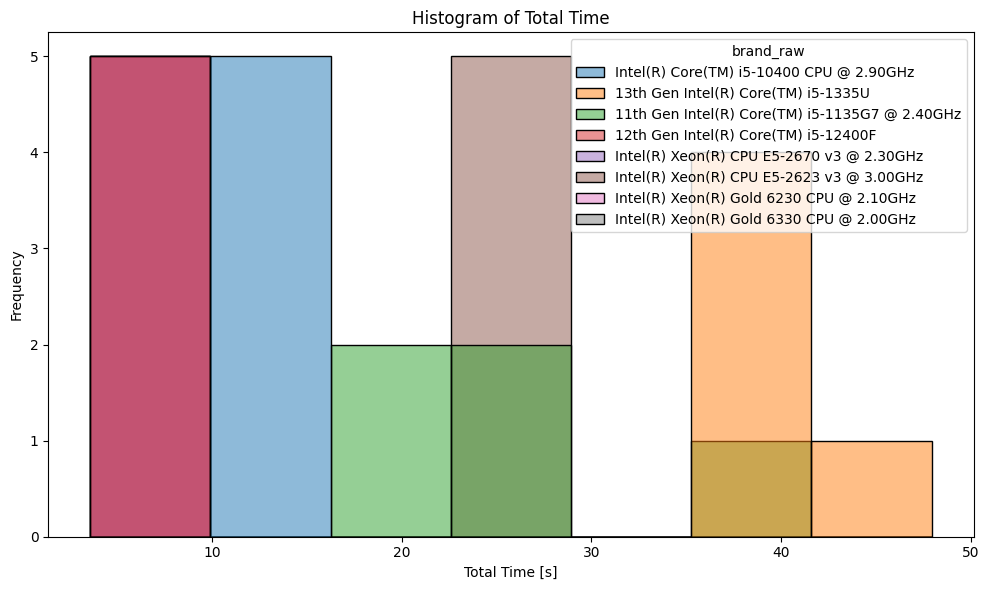

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(mm_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time [s]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

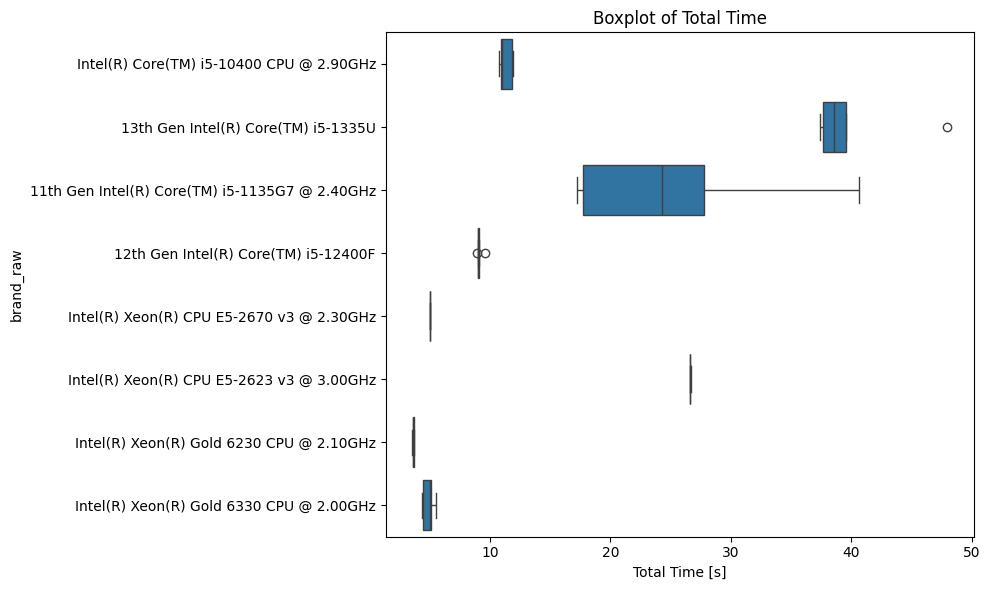

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mm_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time [s]')

plt.tight_layout()
plt.show()

Se puede observar que la distribución del tiempo de ejecución varia bastante dependiendo del procesador usado, una relación bastante trivial. 

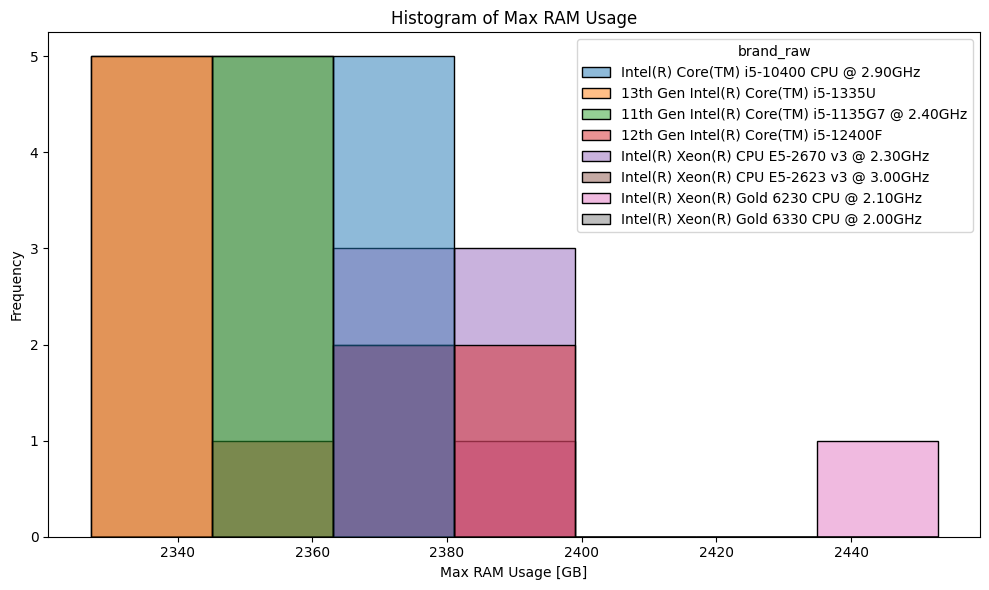

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(mm_df, x='max_ram_usage', hue='brand_raw')
plt.title('Histogram of Max RAM Usage')
plt.xlabel('Max RAM Usage [MB]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

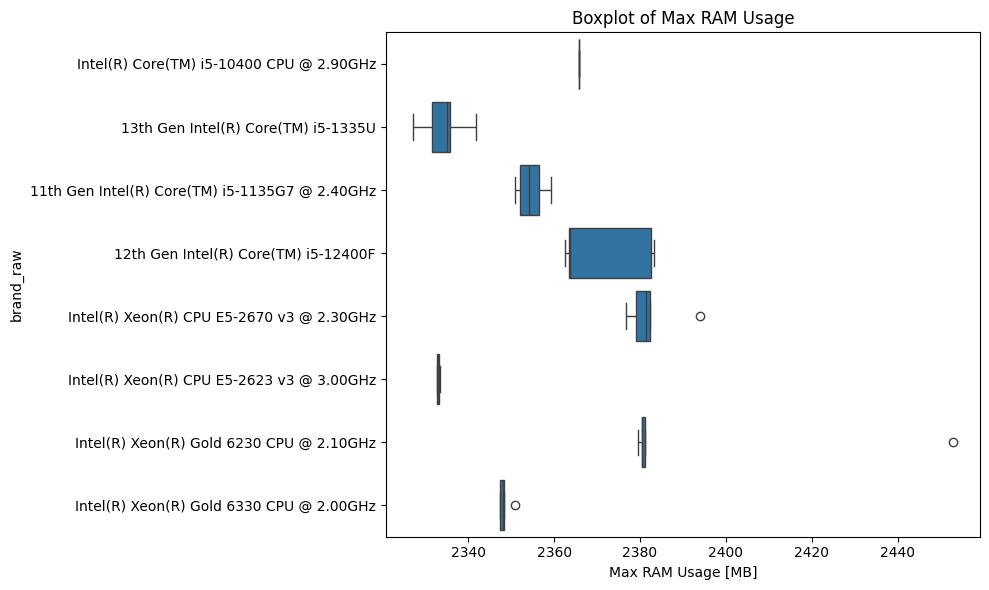

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mm_df, x='max_ram_usage', y='brand_raw')
plt.title('Boxplot of Max RAM Usage')
plt.xlabel('Max RAM Usage [MB]')

plt.tight_layout()
plt.show()

Se puede observar que la RAM maxima utilizada no cambia demasiado, oscilando entre 2.28 GB y 2.33 GB, esto debido a que la cantidad de memoria utilizada es inherente del programa, al menos en este benchmark.

Además se ignorara el procesador `11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz` debido a la gran variabilidad en los tiempos de ejecución, lo cual puede ser debido a factores externos como el calentamiento del procesador, lo cual puede afectar el rendimiento. 

In [22]:
mm_df = mm_df[mm_df['brand_raw'] != "11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz"]
mm_df[['brand_raw','vendor_id_raw','arch','count']].drop_duplicates()

,brand_raw,vendor_id_raw,arch,count
15,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12
35,13th Gen Intel(R) Core(TM) i5-1335U,GenuineIntel,X86_64,12
75,12th Gen Intel(R) Core(TM) i5-12400F,GenuineIntel,X86_64,12
95,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24
115,Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz,GenuineIntel,X86_64,8
135,Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz,GenuineIntel,X86_64,40
155,Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz,GenuineIntel,X86_64,56


Ahora se profundizara en las correlaciones entre las variables medidas en la ejecución y las características de los procesadores para poder entender los atributos que más influyen, en especifico se analizará en el tiempo de ejecución.

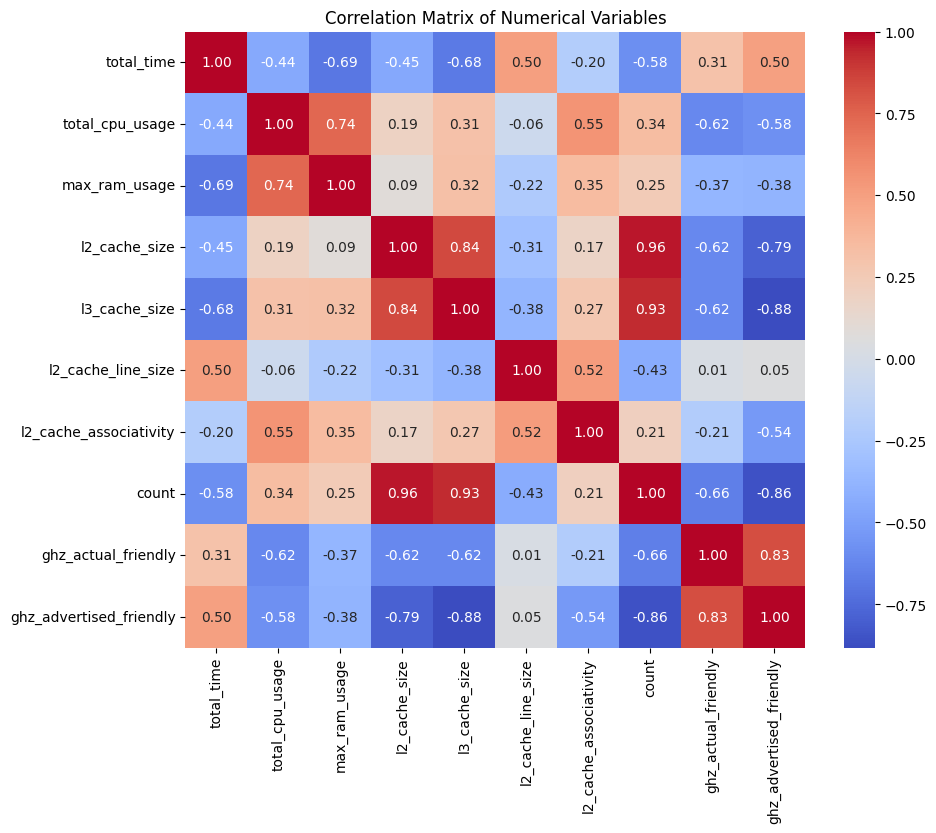

In [23]:
correlation_matrix = mm_df[['total_time', 'total_cpu_usage', 'max_ram_usage','l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

Conclusiones a partir del mapa de correlaciones:
- La correlación negativa entre `total_time` y variables como `l2_cache_size`, `l3_cache_size`, y `count` sugiere que mejorar estos aspectos del hardware puede reducir el tiempo de ejecución.
- La correlación positiva entre `total_time` y `l2_cache_line_size` indica que un mayor tamaño de línea de caché L2 podrían estar asociadas con mayores tiempos de ejecución.
- La alta correlación entre `total_cpu_usage` y `max_ram_usage` sugiere una fuerte interdependencia entre el uso de la CPU y la RAM.

Hay dos puntos a tener en cuenta, con lo mostrado en el mapa de correlaciones:

- **No linealidad**: La correlación entre las variables y el tiempo de ejecución no es lineal de manera general, por lo que un modelo lineal no sería suficiente para capturar la relación entre las variables y el tiempo de ejecución, como en los casos de alta correlación negativa entre `l2_cache_associativity` y `total_time` o alta correlación positiva entre `total_cpu_usage` y `total_time` u otras correlaciones moderadas que sugieren que las relaciones no son estrictamente lineales. Métodos como random forest pueden capturar relaciones no lineales hasta cierto punto, pero pueden volverse demasiado complejos o ineficientes.

- **Multicolinealidad**:  La alta correlación entre variables independientes (como `total_cpu_usage` y `count` con un valor de 0.99), puede causar problemas en una regresión lineal. Esto puede hacer que las estimaciones sean inestables y difíciles de interpretar. Métodos tradicionales podrían requerir un preprocesamiento de las variables para manejar la multicolinealidad (como PCA), lo que añade complejidad al modelo y puede hacerlo menos interpretable.

Aún con los datos obtenidos, muchos procesos computacionales son afectados por factores que pueden no estar directamente medidos o incluidos en el dataset, como variaciones en la carga de trabajo que no se capturan completamente con las variables disponibles, o algunos que se pudieran incluir a futuro como condiciones térmicas, voltaje o incluso las llamadas al sistema que ejecuta el programa.

Las interacciones entre variables, como la combinación de tipo de arquitectura y tamaño de cache, pueden tener efectos importantes en el tiempo total que no son capturables mediante una simple regresión lineal.

Para esto, los modelos de *deep learning* podrían ofrecer mejoras significativas en la predicción de `total_time` como la capacidad de manejar no linealidad, multicolinealidad, interacciones complejas y la posible incorporación de variables categóricas mediante embeddings, incluyendo las **llamadas al sistema** teniendo asi un mayor conocimiento sobre el comportamiento del programa, proporcionando así un modelo más robusto y preciso para predecir **total_time**.

 Ahora se procederá a realizar un análisis de componentes principales para reducir la dimensionalidad de los datos y poder visualizar mejor las relaciones entre las variables, además de poder identificar posibles grupos de variables que puedan ser usadas para modelar el tiempo de ejecución.

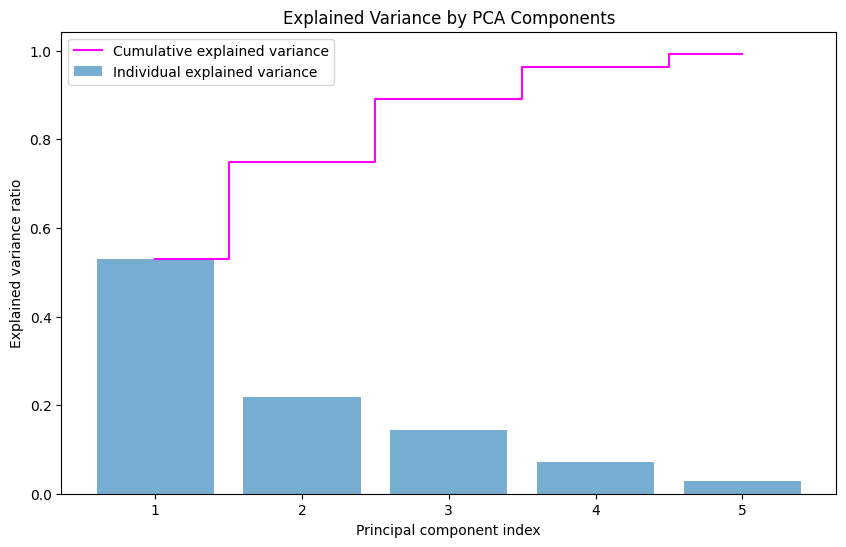

PC1: 0.5288386558542927 | PC2: 0.21904809190859678 | PC3: 0.1429422934627126 | PC4: 0.07247282445413708 | PC5: 0.029809403575427853


In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(mm_df[
    ['total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']
])
pca = PCA(n_components=0.99)  # 99% of varianze
principal_components = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

pca_df = pd.DataFrame(data=principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', color='magenta', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

print(f"PC1: {explained_variance[0]} | PC2: {explained_variance[1]} | PC3: {explained_variance[2]} | PC4: {explained_variance[3]} | PC5: {explained_variance[4]}") 

Los componentes principales resultantes capturan:
- **PC1**: 52.88% de la varianza total.
- **PC2**: 21.9% de la varianza total.
- **PC3**: 14.29% de la varianza total.
- **PC4**: 7.24% de la varianza total.
- **PC5**: 2.98% de la varianza total.

Con estos tres primeros componentes, retenemos aproximadamente el 89% de la varianza total, por lo que podemos considerar que estos componentes capturan la mayor parte de la información relevante de los datos, aunque para tener una variabilidad mayor se podrían considerar los primeros 5 componentes.

Ahora se visualizará la importancia de las variables en cada componente principal, para poder identificar las variables que más influyen en el tiempo de ejecución.

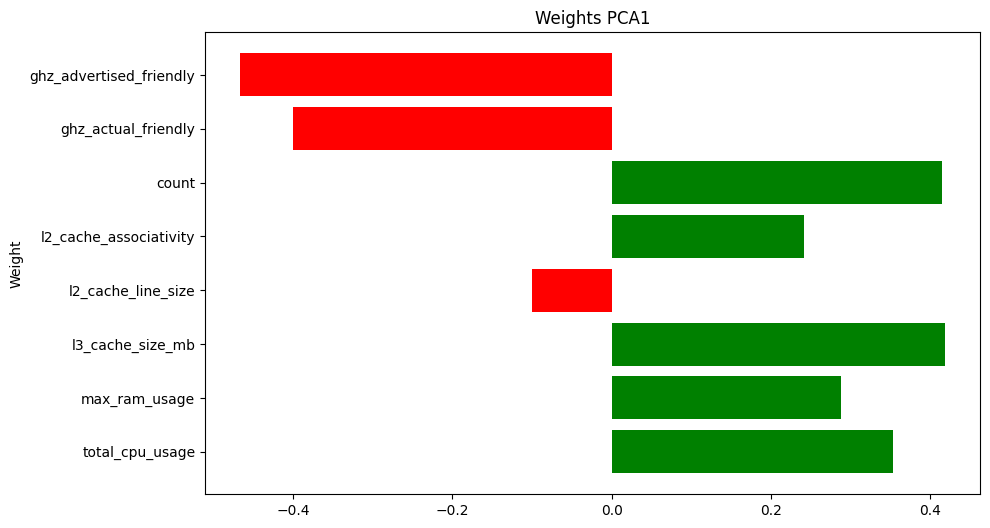

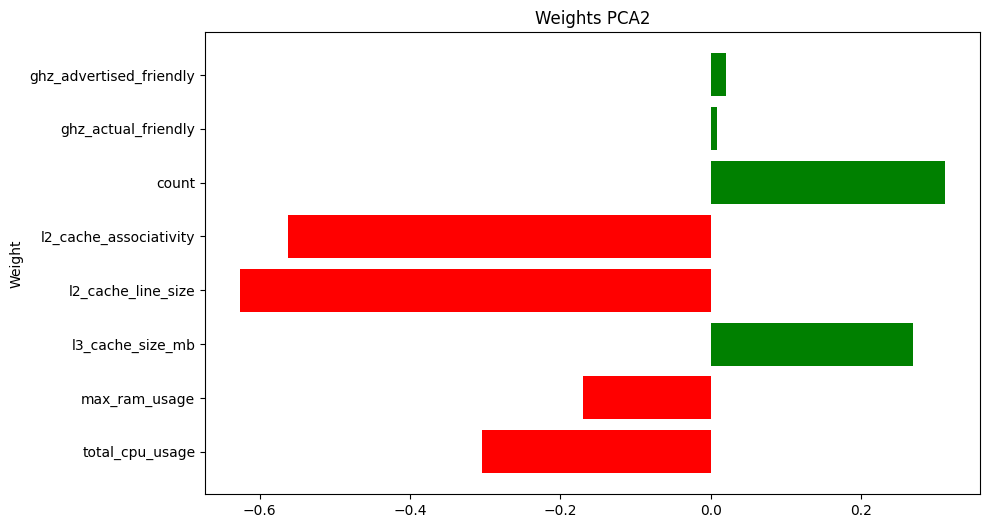

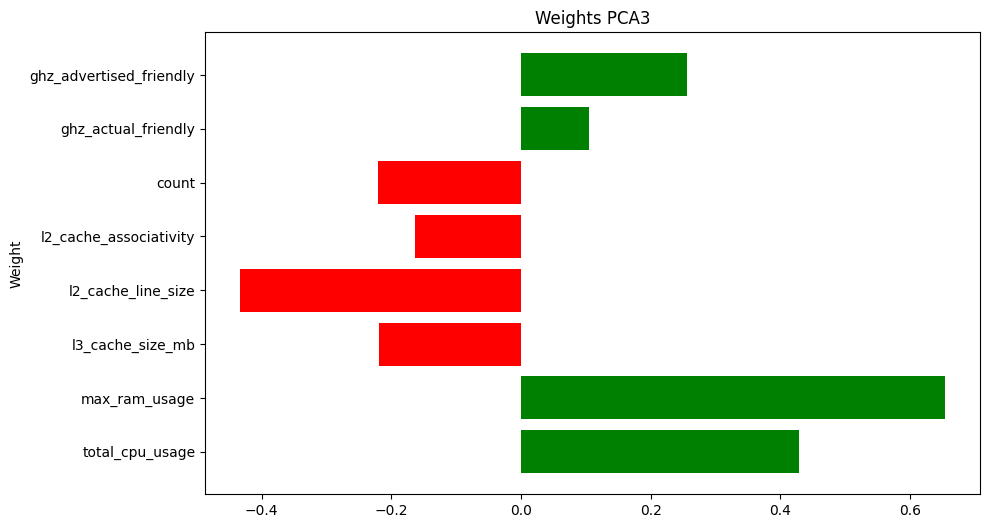

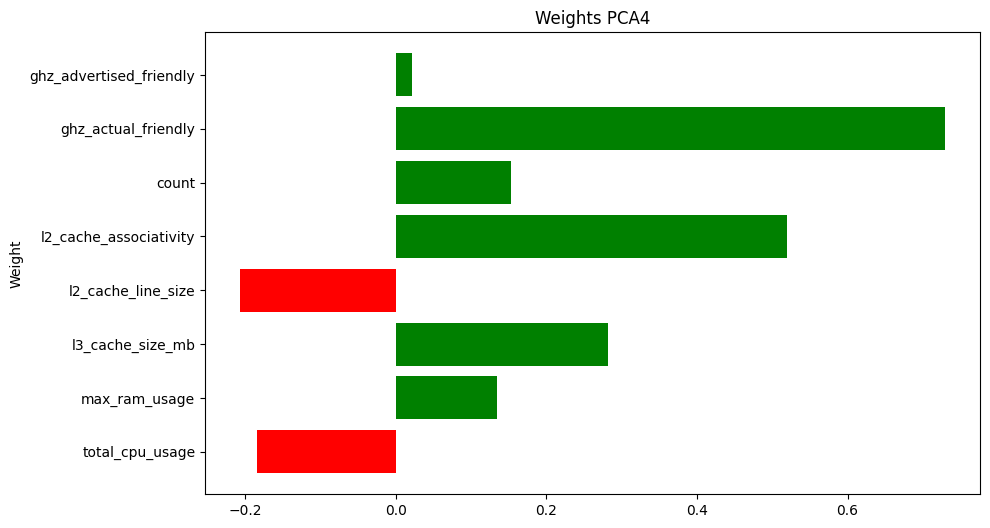

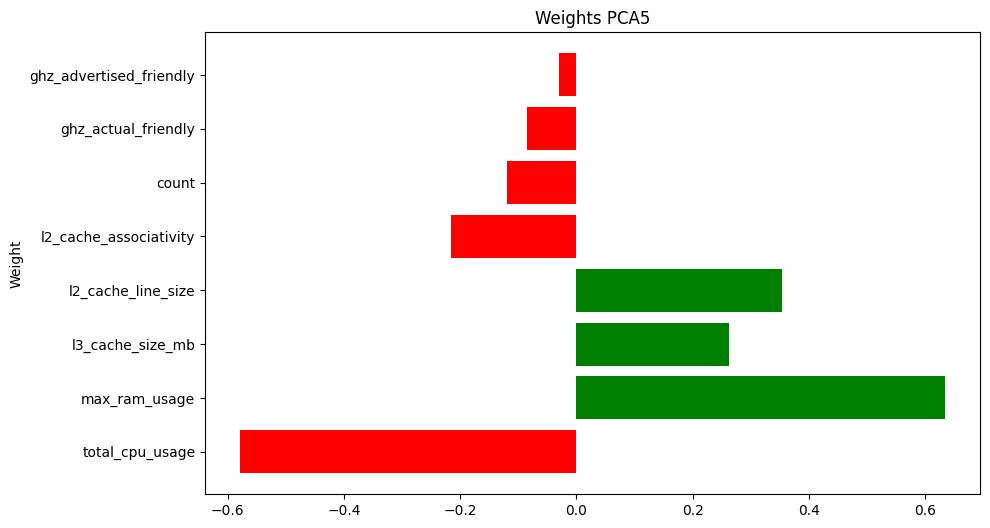

In [25]:
components = pca.components_
num_components = components.shape[0]
features = ['total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']

for i in range(num_components):
    plt.figure(figsize=(10, 6))
    component = components[i]
    colors = ['red' if val < 0 else 'green' for val in component]
    plt.barh(features, component, color=colors)
    plt.ylabel('Weight')
    plt.title(f'Weights PCA{i+1}')
    plt.show()

Los pesos para cada componente principal nos dicen cómo contribuye cada variable original a ese componente:
- Pesos positivos o negativos altos indican una fuerte influencia de la variable en ese componente.
- Pesos cercanos a cero indican una baja influencia.
Estos componentes principales pueden ser utilizados como entradas para los modelos predictivos de `total_time`.

Notar que en el componente principal 3 la variable `max_ram_usage` destaca como la más importante, lo que sugiere que la cantidad de memoria utilizada es un factor importante en el tiempo de ejecución, al menos en aproximadamente un 11.38% de la varianza total. En los otros componentes principales, las variables tienen pesos más equilibrados, lo que sugiere que la influencia de las variables más equitativa.